# **SpaceX  Falcon 9 first stage landing prediction project**


In this project we will predict if the Falcon 9 first stage will land successfully. If we can determine if the first stage will land, we can determine the cost of a launch.

# Stage 1: Collecting, and preparing the data

We will make a get request to the SpaceX API. We will collect and make sure the data is in the correct format from an API.

### Importing necessary libraries

In [651]:
import requests
import pandas as pd
import numpy as np 

Now let's request rocket launch data from SpaceX API with the following URL:

In [654]:
spacex_url="https://api.spacexdata.com/v4/launches/past"

In [656]:
response = requests.get(spacex_url)

After this process, we should see that the request was successfull with the 200 status response code with next code line

In [659]:
response.status_code

200

Now we decode the response content as a Json using .json() and turn it into a Pandas dataframe using .json_normalize()

In [662]:
df = pd.json_normalize(response.json())

Lets check first 5 elements of our dataframe

In [665]:
df.head()

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,None,None,[],[],None,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],None,[],[],...,None,None,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


After checking the first 5 elements, we see that a lot of the data are IDs. For example the rocket column has no information about the rocket just an identification number. This status of df needs adjusting

In [668]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
df = df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket. 
# However we want Falcon 9 rockets.
df = df[df['cores'].map(len)==1]
df = df[df['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
df['cores'] = df['cores'].map(lambda x : x[0])
df['payloads'] = df['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
# To do this, firstly we will import datetime
import datetime
df['date'] = pd.to_datetime(df['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
df = df[df['date'] <= datetime.date(2020, 11, 13)]

We want specific informations from the variables like:
* From the <code>rocket</code> we would like to learn the booster name

* From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

* From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

* From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

**We will define functions to have these purposes.**

From the rocket we would like to learn the booster namee.

In [672]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

From the launchpad we would like to know the name of the launch site being used, the logitude, and the latitude.

In [675]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

From the payload we would like to learn the mass of the payload and the orbit that it is going to.

In [678]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

From cores we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, wheter the core is reused, wheter legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [681]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

The data from these requests will be stored in lists and will be used to create a new dataframe.
So, let's create empty lists

In [684]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

**Now, lets apply those functions**

In [687]:
getBoosterVersion(df)
getLaunchSite(df)
getPayloadData(df)
getCoreData(df)

Finally lets construct our dataset using the data we have obtained. We we combine the columns into a dictionary.

In [689]:
launch_dict = {'FlightNumber': list(df['flight_number']),
'Date': list(df['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

Then, we need to create a Pandas data frame from the dictionary launch_dict.

In [691]:
new_df = pd.DataFrame.from_dict(launch_dict)

Now, lets see how our new dataframe looks like

In [693]:
new_df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


Now, there is one last problem about preparing the data, since we want Falcon 9 launches, we should get rid of Falcon 1 <code>BoosterVersion</code>

In [699]:
data_falcon9 = new_df[new_df['BoosterVersion']=='Falcon 9']
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


Now that we have removed some values we should reset the FlgihtNumber column

In [702]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


Now, we can say that we finished data collection, and preperation

# Stage 2: Data Wrangling

Now, as a first step of data wrangling process, we will check the missing values

In [707]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

We need to deal with those missing values. The missing values for LandingPad will remain same since it represent landing pads not used.
However, for the missing PayloadMass values, we will replace them with the mean of that column.

In [721]:
data_falcon9[["PayloadMass"]] = data_falcon9[["PayloadMass"]].fillna(data_falcon9[["PayloadMass"]].mean())

C:\Users\Ozan\AppData\Local\Temp\ipykernel_17436\402385376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9[["PayloadMass"]] = data_falcon9[["PayloadMass"]].fillna(data_falcon9[["PayloadMass"]].mean())


Now, let's check again

In [724]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

Now, we can see that there are no missing values for PayloadMass anymore.

We will keep continue to adjust our datafreme to make more accurate Exploratory Data Analysis.

In the data set, there are several different cases where the booster did not land successfully. Sometimes a landing was attempted but failed due to an accident; for example, True Ocean means the mission outcome was successfully landed to a specific region of the ocean while False Ocean means the mission outcome was unsuccessfully landed to a specific region of the ocean.

Therefore, now  we will mainly convert those outcomes into Training Labels with 1 means the booster successfully landed 0 means it was unsuccessful.

In [730]:
# We will use the method .value_counts() on the column Outcome to determine the number of landing_outcomes.Then assign it to a variable landing_outcomes.
# landing_outcomes = values on Outcome column
landing_outcomes = data_falcon9[["Outcome"]].value_counts()
landing_outcomes

for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 ('True ASDS',)
1 ('None None',)
2 ('True RTLS',)
3 ('False ASDS',)
4 ('True Ocean',)
5 ('False Ocean',)
6 ('None ASDS',)
7 ('False RTLS',)


We create a set of outcomes where the second stage did not land successfully:

In [733]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{('False ASDS',),
 ('False Ocean',),
 ('False RTLS',),
 ('None ASDS',),
 ('None None',)}

Using the Outcome, we will create a list where the element is zero if the corresponding row in Outcome is in the set bad_outcome; otherwise, it's one. Then assign it to the variable **landing_class**:

In [736]:
# landing_class = 0 if bad_outcome
# landing_class = 1 otherwise
landing_class = []
for row in data_falcon9["Outcome"]:
    if "True" in row:
        landing_class.append(1)
    else:
        landing_class.append(0)


**landing_class** variable will represent the classification variable that represents the outcome of each launch. If the value is zero, the first stage did not land successfully; one means the first stage landed Successfully

In [739]:
# In order to this variable helps us, we will add it to our dataframe
data_falcon9['Class']=landing_class
data_falcon9[['Class']].head()

C:\Users\Ozan\AppData\Local\Temp\ipykernel_17436\949472786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class']=landing_class


,Class
4,0
5,0
6,0
7,0
8,0


For now, we adjusted our dataframe to EDA be applied.

# Stage 3: EDA and Future Engineering

To apply EDA, let's import necessary libraries

In [744]:
import matplotlib.pyplot as plt
import seaborn as sns

Let's look in detail at each site and visualize its detailed launch records.

C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


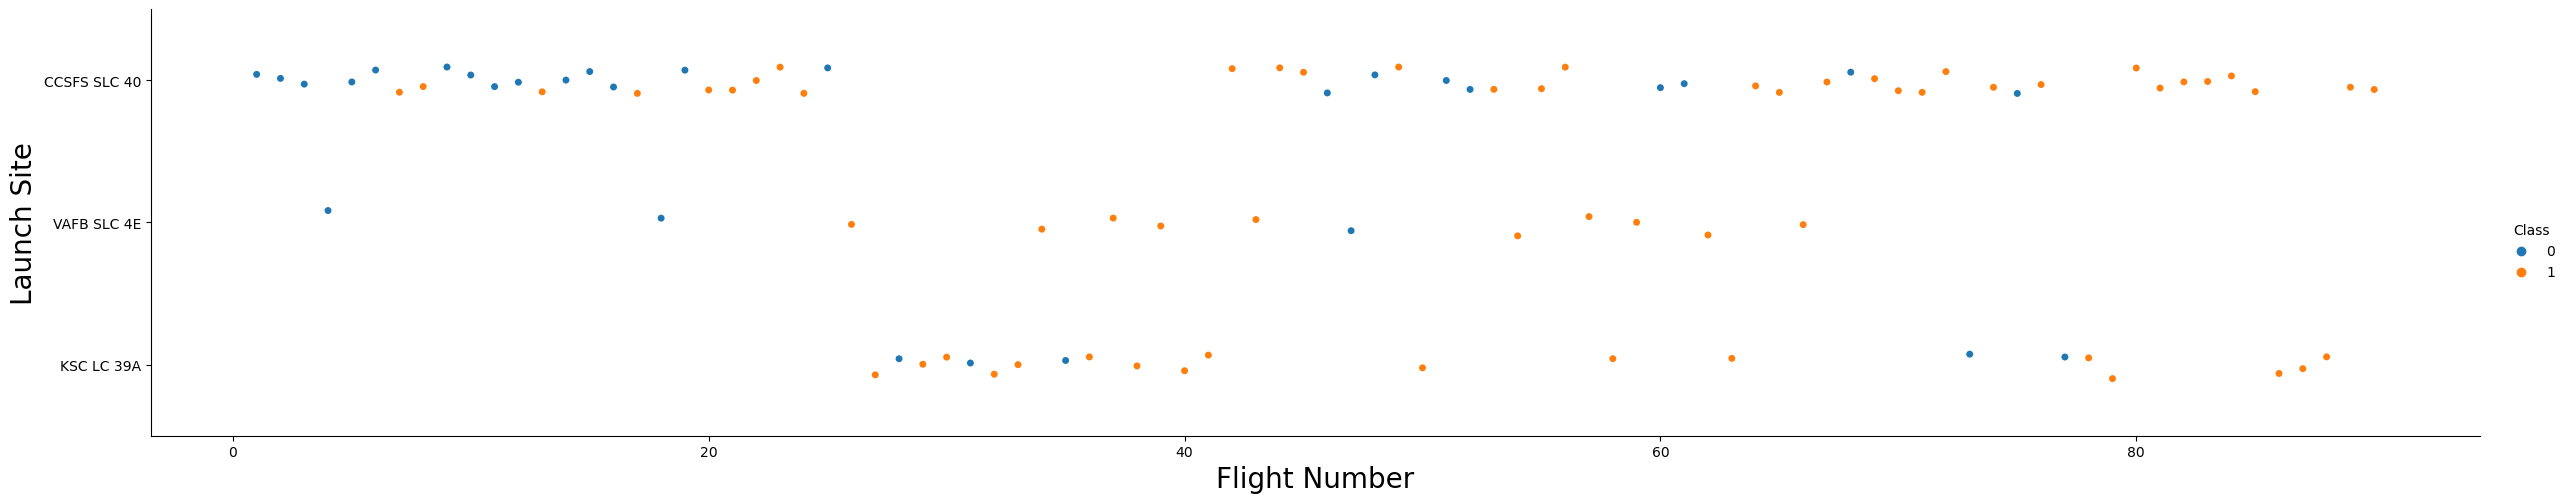

In [747]:
sns.catplot(x='FlightNumber', y='LaunchSite', hue='Class', data=data_falcon9, aspect=5)
plt.xlabel('Flight Number', fontsize=20)
plt.ylabel('Launch Site', fontsize=20)
plt.show()

**Findings**:
* The earliest flights all failed while the latest flights all succeeded.
* It can be assumed that each new launch has a higher rate of success.

Now, let's try to see if there is any relationship between launch sites and their payload mass.

C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


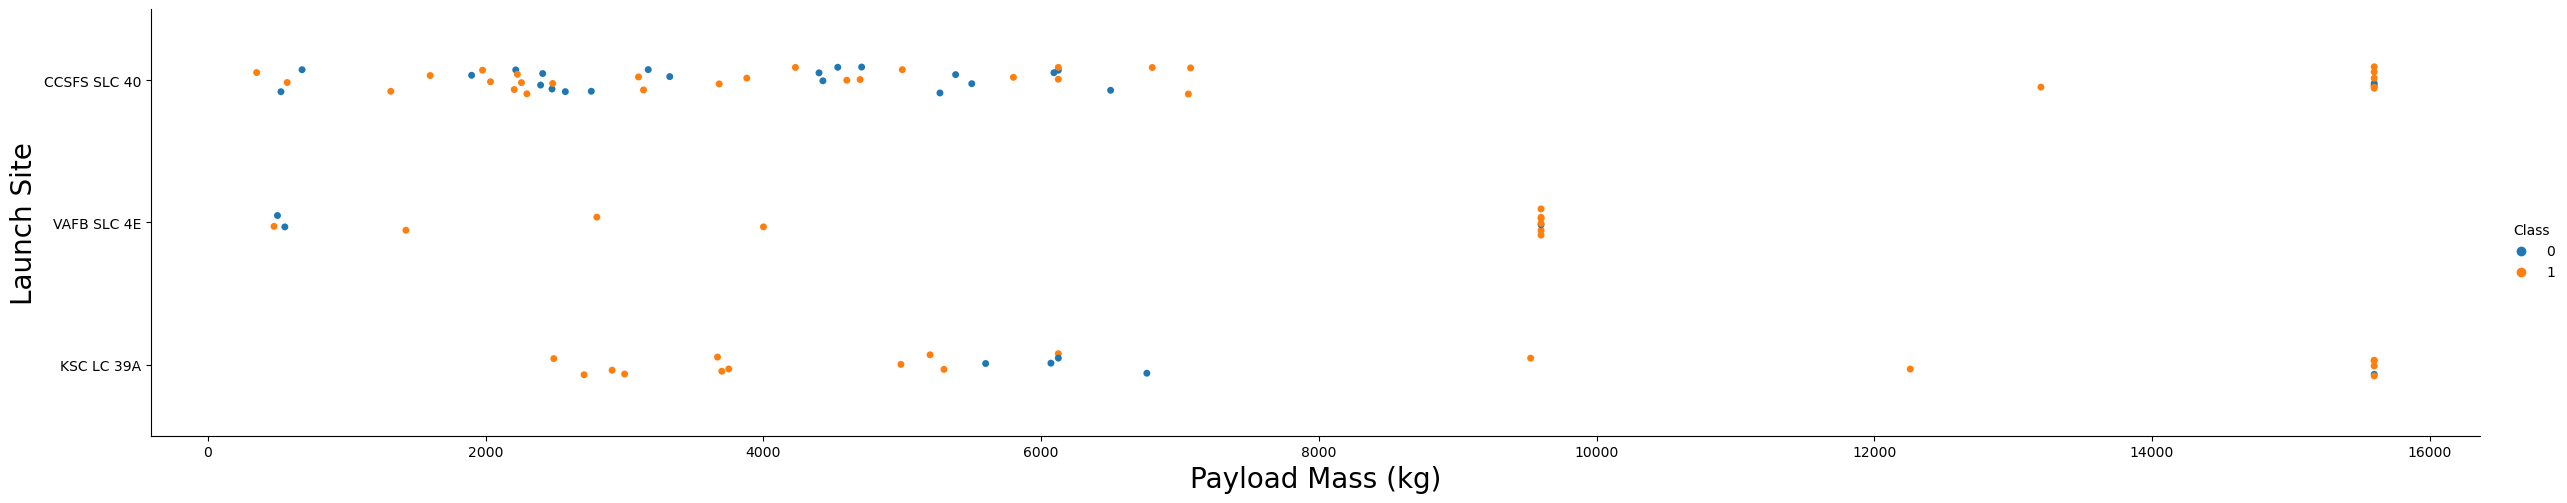

In [751]:
sns.catplot(x='PayloadMass', y='LaunchSite', hue='Class', data=data_falcon9, aspect = 5)
plt.xlabel('Payload Mass (kg)',fontsize=20)
plt.ylabel('Launch Site',fontsize=20)
plt.show()

**Findings**:

* For every launch site the higher the payload mass, the higher the success rate.
* Most of the launches with payload mass over 7000 kg were successfull.

Next, we want to visually check if there are any relationship between success rate and orbit type.

Let's create a bar chart for the sucess rate of each orbit

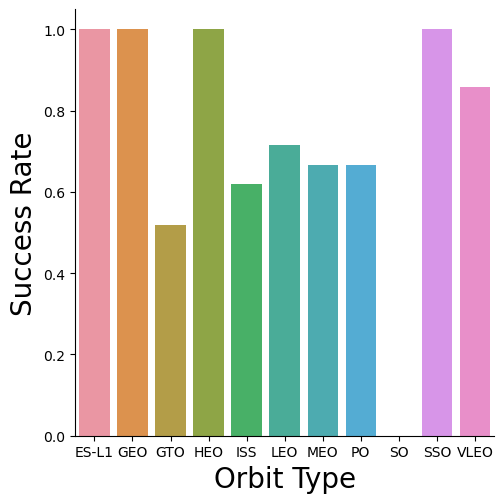

In [755]:
sns.catplot(x= 'Orbit', y = 'Class', data = data_falcon9.groupby('Orbit')['Class'].mean().reset_index(), kind = 'bar')
plt.xlabel('Orbit Type',fontsize=20)
plt.ylabel('Success Rate',fontsize=20)
plt.show()

**Findings**:

Orbits with 100% success rate:
* ES-L1
* GEO
* HEO
* SSO

Orbits with 0% success rate:
* SO

Now, for each orbit, we want to see if there is any relationship between FlightNumber and Orbit type.

C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


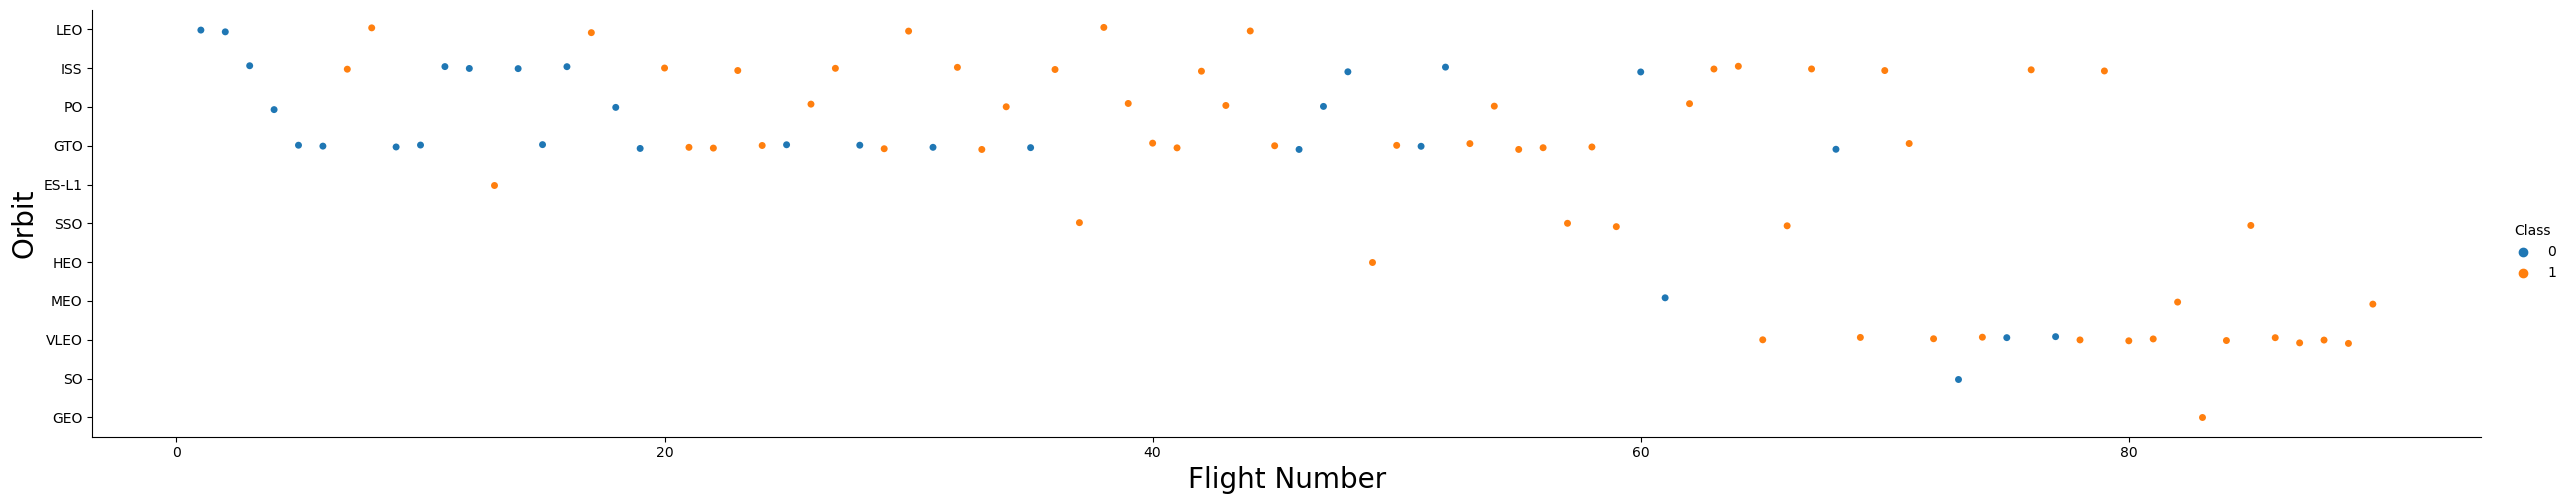

In [759]:
sns.catplot(x = 'FlightNumber', y = 'Orbit', hue = 'Class', data = data_falcon9, aspect = 5)
plt.xlabel('Flight Number', fontsize = 20)
plt.ylabel('Orbit', fontsize = 20)
plt.show()

We can see that in the LEO orbit the success appears related to the number of flights; on the other hand, there seems to be no relationship between flight number when in GTO orbit.

**We obtained some preliminary insights about how each important variable would affect the success rate, for the next, we will select the features that will be used in success prediction in the future module.**

### Future Engineering

In [764]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


To convert categorical variables into a numerical format, we will apply one hot encoding

We see that categorical variables are <code>Orbits</code>, <code>LaunchSite</code>, <code>LandingPad</code>, <code>Serial</code>, <code>GridFins</code>, <code>Reused</code>, <code>Legs</code>

Therefore, we will Use the function get_dummies and features dataframe to apply OneHotEncoder to the column Orbits, LaunchSite, LandingPad, and Serial. We will assign the value to a variable.

In [769]:
features_one_hot = pd.get_dummies(features, columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial', 'GridFins', 'Reused', 'Legs'])
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
4,1,6123.547647,1,1.0,0,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
5,2,525.000000,1,1.0,0,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
6,3,677.000000,1,1.0,0,False,False,False,False,True,...,False,False,False,False,True,False,True,False,True,False
7,4,500.000000,1,1.0,0,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
8,5,3170.000000,1,1.0,0,False,False,True,False,False,...,False,False,False,False,True,False,True,False,True,False


In [771]:
# In order to make dataframe only contains numbers
features_one_hot = features_one_hot.astype('float64')
features_one_hot.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
4,1.0,6123.547647,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


Since feature engineering is completed, we can proceed with Modelling

# Stage 4: Machine Learning Prediction with Classification Algorithms

In this stage:

* Firstly, we will import the libraries we will need.
* Secondly, we will extract our X and Y variables.
* Then, we will standardize our X and use train_test_split function to split our data.
* After that, we will determine the best parameters for the classification algorithms with GridSearch, and make our prediction.
* Finally, we will choose best classification algorithm by considering some metrics.

In [776]:
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

As a next step, we will assign our success data to variable **Y**

In [779]:
Y = data_falcon9["Class"].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

Now, in order to standardize our data, we will use our one hot encoded dataframe and assign the value to **X** variable

In [782]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(features_one_hot)

After standardization, we split the data into training and testing data using the function train_test_split.

In [787]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

Now we can apply GridSearch to our different algorithms

#### Algorithm 1: Logistic Regression

Now, we will create a GridSearchCV object logreg_cv with cv = 10. We will fit the object to find the best parameters from the dictionary parameters.

In [792]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

logreg=GridSearchCV(lr, parameters, cv=10)
logreg.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

Let's look at our best parameter and score

In [795]:
print("Best parameters: ", logreg.best_params_)
print("Accuracy :",logreg.best_score_)

Best parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.8464285714285713


We want to make test on our test data, therefore we will calculate the accuracy on the test data using the score method

In [798]:
logreg_accuracy = logreg.score(X_test, Y_test)
logreg_accuracy

0.8333333333333334

Now, lets try a different algorithm.

#### Algorithm 2: Support Vector Machine

In [802]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
SVM = SVC()

svm = GridSearchCV(SVM, parameters, cv=10)
svm.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

Let's look at our best parameter and score

In [805]:
print("Best Parameters: ", svm.best_params_)
print("Accuracy :", svm.best_score_)

Best Parameters:  {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
Accuracy : 0.8357142857142856


We want to make test on our test data, therefore we will calculate the accuracy on the test data using the score method

In [808]:
svm_accuracy = svm.score(X_test, Y_test)
svm_accuracy

0.8333333333333334

#### Algorithm 3: Decision Tree

In [812]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

TREE = DecisionTreeClassifier()

tree = GridSearchCV(TREE, parameters, cv=10)
tree.fit(X_train, Y_train)

C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\anaconda3\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in valid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [816]:
print("Best parameters: ", tree.best_params_)
print("Accuracy :", tree.best_score_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Accuracy : 0.875


We want to make test on our test data, therefore we will calculate the accuracy on the test data using the score method

In [819]:
tree_accuracy = tree.score(X_test, Y_test)
tree_accuracy

0.8333333333333334

**We did same applications with different algorithms and we realized that decision tree algorithm gave better accuracy score until now.**

Let's apply our last algorithm which is K Nearest Neighbor

#### Algorithm 4: K Nearest Neighbor

In [824]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn = GridSearchCV(KNN, parameters, cv=10)
knn.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [826]:
print("Best Parameters: ", knn.best_params_)
print("Accuracy :", knn.best_score_)

Best Parameters:  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy : 0.8482142857142858


We want to make test on our test data, therefore we will calculate the accuracy on the test data using the score method

In [829]:
knn_accuracy = knn.score(X_test, Y_test)
knn_accuracy

0.8333333333333334

#### Finding Best Algorithm

By using metrics, we will find the best algorithm

We saw that every algoritm gave 0.8333333333333334 accuracy on the test data. Therefore we cannot examine the accuracy on test data, they all same

However, they gave different scores on the training data.

Therefore, to choose best one, we will examine the scores on whole data.

In [836]:
# Firstly, we will import the metrics we will use
from sklearn.metrics import jaccard_score, f1_score

# Let's investigate scores now.
jaccard_scores = [jaccard_score(Y, logreg.predict(X), average='binary'),
                  jaccard_score(Y, knn.predict(X), average='binary'),
                  jaccard_score(Y, svm.predict(X), average='binary'),
                  jaccard_score(Y, tree.predict(X), average='binary'),]

f1_scores = [f1_score(Y, logreg.predict(X), average='binary'),
             f1_score(Y, knn.predict(X), average='binary'),
             f1_score(Y, svm.predict(X), average='binary'),
             f1_score(Y, tree.predict(X), average='binary'),]

accuracy = [logreg.score(X, Y), knn.score(X, Y), svm.score(X, Y), tree.score(X, Y)]

Let's look at scores for each algorithm

In [839]:
print("Logistic Regression Scores: ", "Jaccard Score: ", jaccard_scores[0], "F1 Score: ", f1_scores[0], "Accuracy: ", accuracy[0])
print("KNN Scores: ", "Jaccard Score: ", jaccard_scores[1], "F1 Score: ", f1_scores[1], "Accuracy: ", accuracy[1])
print("SVM Scores: ", "Jaccard Score: ", jaccard_scores[2], "F1 Score: ", f1_scores[2], "Accuracy: ", accuracy[2])
print("Decision Tree Scores: ", "Jaccard Score: ", jaccard_scores[3], "F1 Score: ", f1_scores[3], "Accuracy: ", accuracy[3])

Logistic Regression Scores:  Jaccard Score:  0.8333333333333334 F1 Score:  0.9090909090909091 Accuracy:  0.8666666666666667
KNN Scores:  Jaccard Score:  0.8194444444444444 F1 Score:  0.9007633587786259 Accuracy:  0.8555555555555555
SVM Scores:  Jaccard Score:  0.9090909090909091 F1 Score:  0.9523809523809523 Accuracy:  0.9333333333333333
Decision Tree Scores:  Jaccard Score:  0.8870967741935484 F1 Score:  0.9401709401709402 Accuracy:  0.9222222222222223


### Conclusion

* The scores of the whole dataset confirm that the best model is the **SVM** Model. This model has not only higher scores, but also the highest accuracy.